# 4.1 The Data

In [547]:
import os
import numpy as np
import pickle
import random

'''
Note: No obligation to use this code, though you may if you like.  Skeleton code is just a hint for people who are not familiar with text processing in python. 
It is not necessary to follow. 
'''

def read_data_1grams(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(None, symbols).strip(), lines)
    words = filter(None, words)
    return words



def folder_list(path,label, read_data_func = read_data_1grams):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data_func(file)
        r.append(label)
        review.append(r)
    return review
###############################################
######## YOUR CODE STARTS FROM HERE. ##########
###############################################


def read_data_bigrams(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(None, symbols).strip(), lines)
    words = filter(None, words)
    bigrams = ['{} {}'.format(words[i], words[i+1]) for i in range(len(words)-1)]
    words.extend(bigrams)
    return words

def shuffle_data(pickle_path = "all_data_pickled.p", feature_set_func = read_data_1grams):
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    pickle_path is where you save the data
    '''
    neg_path = "/Users/benjaminjakubowski/Desktop/MS_Courses/ML/HW_assignments/Assignment3/hw3-sentiment/data/neg"
    pos_path = "/Users/benjaminjakubowski/Desktop/MS_Courses/ML/HW_assignments/Assignment3/hw3-sentiment/data/pos"
    
    pos_review = folder_list(pos_path,1, feature_set_func)
    neg_review = folder_list(neg_path,-1, feature_set_func)
    
    review = pos_review + neg_review
    random.seed(1325614)
    random.shuffle(review)
    
    #Now you have read all the files into list 'review' and it has been shuffled.
    #Save your shuffled result by pickle.
    #*Pickle is a useful module to serialize a python object structure.
    #*Check it out. https://wiki.python.org/moin/UsingPickle
    pickle.dump(review, open( pickle_path, "wb" ) )
    return

def train_test_split(num_train = 1500, num_test = 500, pickle_path = "all_data_pickled.p"):
    all_data = pickle.load( open( pickle_path, "rb" ) )
    train_data = all_data[0:num_train]
    test_data = all_data[num_train:]
    return train_data, test_data

In [548]:
shuffle_data()
train_data, test_data = train_test_split()

In [549]:
len(train_data)

1500

In [550]:
len(test_data)

500

# 5.1 Sparse Representations


In [551]:
from collections import Counter

def sparsify(example):
    '''
    Sparsify produces a sparse representation of an input list of words.
    
    Args:
        example- a list of words
        
    Returns:
        sparse_example- a 'Counter' sparse version of the input example
    '''
    return Counter(example)


# SVM via Pegasos- helper funcions

In [552]:
#Provided helper functions:

# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code

def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def scale_and_increment(d1, scale_d1, d2 = Counter(), scale_d2 = 0.0):
    """
    Implements d1 = scale_d1 * d1 + scale * d2 for sparse vectors.
    
    Args:
        d1 - the feature vector which is mutated (input Counter object)
        scale_d1 - scale for d1
        d2 - the incrementing feature vector (not mutated)
        scale_d2 - scale for d2
        

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d1.items():
        d1[f] = scale_d1 * v
        
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + scale_d2 * v

def scale_and_increment(d1, scale_d1, d2 = Counter(), scale_d2 = 0.0):
    """
    Implements d1 = scale_d1 * d1 + scale * d2 for sparse vectors.
    
    Args:
        d1 - the feature vector which is mutated (input Counter object)
        scale_d1 - scale for d1
        d2 - the incrementing feature vector (not mutated)
        scale_d2 - scale for d2
        

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d1.items():
        d1[f] = scale_d1 * v
    
    if len(d2) != 0:
        for f, v in d2.items():
            d1[f] = d1.get(f, 0) + scale_d2 * v

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

# 6.2 Initial version of PEGASOS

In [553]:
def sparse_SVM_via_pegasos(training_data, max_epochs, lambda_reg, epsilon = 0.001):
    
    m = len(training_data)
    
    ## First sparsify all training_data:
    sparse_training = []
    for obs in training_data:
        sparse_obs = {}
        sparse_obs['xi'] = sparsify(obs[:-1])
        sparse_obs['yi'] = obs[-1]
        sparse_training.append(sparse_obs)
    
    delta_ws_for_convergence = []
    w_0 = Counter() ###Counter returns a zero count for missing items
    w = Counter()
    t = 0.0
    less_than_epsilon = False
    while not (less_than_epsilon or t > max_epochs*m):
        print t/m
        for obs in sparse_training:
            t += 1.0
            eta_t = 1.0 / (t * lambda_reg)
            if obs['yi']*dotProduct(obs['xi'],w) < 1.0:
                scale_d1 = 1.0 - eta_t *lambda_reg
                scale_d2 = eta_t * obs['yi']
                scale_and_increment(d1 = w, scale_d1 = scale_d1, d2 = obs['xi'], scale_d2 = scale_d2)
            else:
                scale_d1 = 1.0 - eta_t *lambda_reg
                scale_and_increment(d1 = w, scale_d1 = scale_d1)

        delta_w = sum([v for f, v in (w - w_0).items()])**(0.5)
        less_than_epsilon = (delta_w < epsilon)       
        delta_ws_for_convergence.append(delta_w)
        less_than_epsilon = (delta_w < epsilon)
        if less_than_epsilon:
            print 'less than epsilon at t = {}'.format(t)
        w_0 = Counter({f:v for f, v in w.items()})            
        
    return w, delta_ws_for_convergence

In [554]:
ten_iter_results = sparse_SVM_via_pegasos(train_data, max_epochs=10, lambda_reg=0.1, epsilon = 0.001)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


# 6.3 Efficient version fo PEGASOS (exploit sparsity in x)

In [555]:
def sparse_SVM_via_pegasos_with_W(training_data, max_epochs, lambda_reg, sparsified = False, epsilon = 0.001, check_convergence = True):
    '''
    Implements SVM via PEGASOS, exploiting sparsity of x_i's.
    
    Args:
        training_data - training set. See 'sparsified' arg for details.
        max_epochs - maximum number of epochs in the PEGASOS algorithm
        lambda_reg - regularization hyperparamater
        sparsified - if data already sparsified (list of dicts), then True. Else false implies sparsification necessary
        epsilon - threshold for convergence
        check_convergend - if True, measure change in w at each epoch, and use
        epsilon as threshold for convergence. If not, run till max_epochs (save
        time on convergence checking calculations).
            
    Returns:
        w - the final sparse weight vector (after termination)
        delta_ws_for_convergence - change in w's for each epoch
    '''

    m = len(training_data)
    
    ## First sparsify all training_data:
    if not sparsified:
        sparse_training = []
        for obs in training_data:
            sparse_obs = {}
            sparse_obs['xi'] = sparsify(obs[:-1])
            sparse_obs['yi'] = obs[-1]
            sparse_training.append(sparse_obs)
    else:
        sparse_training = training_data
        
    delta_ws_for_convergence = []
    
    W_0 = Counter() ###Counter returns a zero count for missing items
    W = Counter()
    s = 1.0
    s_0 = s
    t = 0.0
    less_than_epsilon = False
    
    print lambda_reg
    while not (less_than_epsilon or t > max_epochs*m):
        if t/m % 10 == 0:
            print t/m
        for obs in sparse_training:
            t += 1.0
            eta_t = 1.0 / (t * lambda_reg)
            s = (1 - eta_t * lambda_reg) * s
            
            if s == 0.0:
                print 'inside s==0 statement at t = {}'.format(t)
                s = 1
                W = Counter()
                continue
            
            if obs['yi']*dotProduct(obs['xi'],W) < 1.0/s:
                increment(d1 = W, scale = 1.0 / s * eta_t * obs['yi'], d2 = obs['xi'])
            else:
                pass
        
        if check_convergence:
            delta_w = sum((Counter({f: s*v for f, v in W.items()}) - Counter({f: s_0*v for f, v in W_0.items()})).values())**(0.5)
            delta_ws_for_convergence.append(delta_w)
            less_than_epsilon = (delta_w < epsilon)
            if less_than_epsilon:
                print 'less than epsilon at t = {}'.format(t)
            W_0 = Counter({f:v for f, v in W.items()})     
            s_0 = s
        
    return Counter({f:s*v for f, v in W.items()}), delta_ws_for_convergence 

In [692]:
ten_iter_results_W = sparse_SVM_via_pegasos_with_W(train_data, max_epochs=10, lambda_reg=0.1, epsilon = 0.001)

# 6.4 Comparing results from both versions of Pegasos

In [687]:
%timeit sparse_SVM_via_pegasos_with_W(train_data, max_epochs=10, lambda_reg=0.1, epsilon = 0.001, check_convergence = False)
%timeit sparse_SVM_via_pegasos_with_W(train_data, max_epochs=10, lambda_reg=0.1, epsilon = 0.001, check_convergence = True)
%timeit sparse_SVM_via_pegasos(train_data, max_epochs = 10, lambda_reg=0.1, epsilon = 0.001)

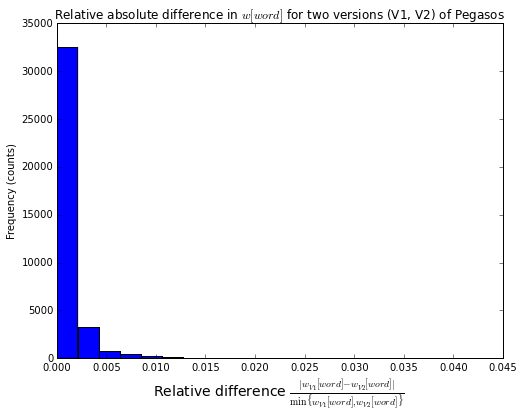

In [745]:
abs_diffs = ((ten_iter_results_W[0]-ten_iter_results[0])+(ten_iter_results[0]-ten_iter_results_W[0]))
maxes = Counter({v: min(a[v], b[v]) for v in (a.keys() + b.keys())})
rel_diffs = {v: abs_diffs[v]/handle0(maxes[v]) for v in abs_diffs.keys()}

plt.figure(figsize=(8,6))
plt.hist(rel_diffs.values(), bins=20)
plt.title(r'Relative absolute difference in $w[word]$ for two versions (V1, V2) of Pegasos')
plt.xlabel(r'Relative difference $\frac{\left|w_{V1}[word] - w_{V2}[word]\right|}{\min\{w_{V1}[word],w_{V2}[word]\}} $ ', fontsize=14)
plt.ylabel('Frequency (counts)')
plt.savefig('figures/6_4.png')

In [729]:
a = Counter({'fish': 0.631, 'string': 2.3, 'word': 2.6})
b = Counter({'other': 0.31, 'string': 1.3, 'word': 3.6})

c = b.keys() + a.keys()
c

c = {v: max(a[v], b[v]) for v in (a.keys() + b.keys())}
c

{'fish': 0.631, 'other': 0.31, 'string': 2.3, 'word': 3.6}

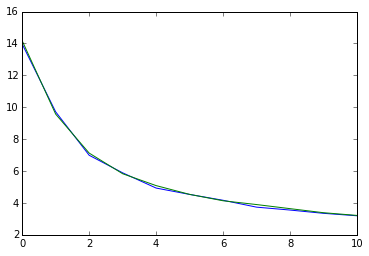

In [694]:
plt.plot(np.arange(11), ten_iter_results_W[1][0:11])
plt.plot(np.arange(11), ten_iter_results[1][0:11])

# 6.5 Sparse 0-1 loss function

In [559]:
def sparse_0_1_loss(weight_vec, test_set):
    '''
    A function that takes a sparse weight vector weight_vec and a collection of (x,y) pairs (test_set)
    and returns the percent error when predicting y using sign(wx). In other words, the function reports
    the 0-1 loss of the linear predictor x 􏰀→ wx.
    
    Args:
        weight_vec - sparse weight vector (Counter object)
        test_set - validation data (iterable collection of obs dictionaries, with obs['xi'] and obs['yi'])
    
    Returns:
        average 0-1 loss
    '''
    total_loss = 0.0
    for obs in test_set:
        loss_on_obs = (np.sign(dotProduct(weight_vec,obs['xi'])) != obs['yi'])
        if loss_on_obs:
            total_loss += 1.0
    
    return total_loss / len(test_set)

# 6.6 Finding optimal lambda using bag-of-words representation

In [569]:
def lambda_search(lambdas, train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = True):

    ## First sparsify all test_:
    sparse_testing = []
    for obs in test_data:
        sparse_obs = {}
        sparse_obs['xi'] = sparsify(obs[:-1])
        sparse_obs['yi'] = obs[-1]
        sparse_testing.append(sparse_obs)
        
        
    ## sparsify all training:
    sparse_training = []
    for obs in train_data:
        sparse_obs = {}
        sparse_obs['xi'] = sparsify(obs[:-1])
        sparse_obs['yi'] = obs[-1]
        sparse_training.append(sparse_obs)
    
    convergence_hists = {}
    loss_vals = []
    for lambda_reg in lambdas:
        weights, convergence = sparse_SVM_via_pegasos_with_W(sparse_training, max_epochs, lambda_reg, sparsified = True, epsilon = epsilon, check_convergence = check_convergence)
        loss_vals.append([lambda_reg, sparse_0_1_loss(weights, sparse_testing)])
        convergence_hists[lambda_reg] = convergence
    
    return np.array(loss_vals), convergence_hists

In [570]:
lambdas = np.logspace(-7,3,11)

In [571]:
lambdas

array([  1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
         1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
         1.00000000e+02,   1.00000000e+03])

In [573]:
search_results = lambda_search(lambdas, train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = True)

1e-07
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1e-06
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1e-05
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.0001
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.001
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.01
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.1
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
10.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
100.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1000.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
less than epsilon at t = 75000.0


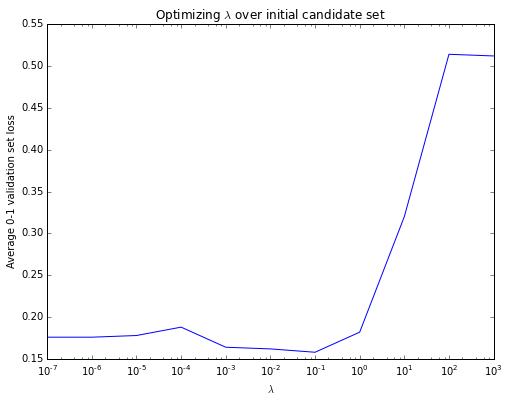

In [598]:
plt.figure(figsize=(8,6))
plt.plot(search_results[0][:,0], search_results[0][:,1])
plt.xscale('log')
plt.ylabel('Average 0-1 validation set loss')
plt.xlabel(r'$\lambda$')
plt.title(r'Optimizing $\lambda$ over initial candidate set')
plt.savefig('figures/6_6_a.png')

In [575]:
print search_results[0]

[[  1.00000000e-07   1.76000000e-01]
 [  1.00000000e-06   1.76000000e-01]
 [  1.00000000e-05   1.78000000e-01]
 [  1.00000000e-04   1.88000000e-01]
 [  1.00000000e-03   1.64000000e-01]
 [  1.00000000e-02   1.62000000e-01]
 [  1.00000000e-01   1.58000000e-01]
 [  1.00000000e+00   1.82000000e-01]
 [  1.00000000e+01   3.20000000e-01]
 [  1.00000000e+02   5.14000000e-01]
 [  1.00000000e+03   5.12000000e-01]]


(0, 20)

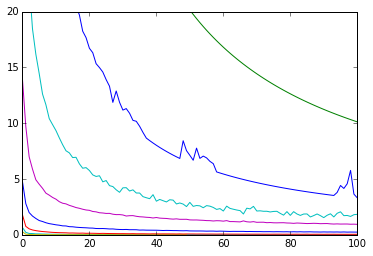

In [576]:
plt.figure()
for i in search_results[1]:
    plt.plot(np.arange(len(search_results[1][i])), search_results[1][i], label=i)
#plt.legend(loc='upper left')
plt.ylim((0,20))

In [577]:
np.logspace(-3,0,10)

array([ 0.001     ,  0.00215443,  0.00464159,  0.01      ,  0.02154435,
        0.04641589,  0.1       ,  0.21544347,  0.46415888,  1.        ])

In [580]:
search_results1 = lambda_search(np.logspace(-3,0,10), train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = False)

0.001
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.00215443469003
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.00464158883361
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.01
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.0215443469003
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.0464158883361
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.1
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.215443469003
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.464158883361
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


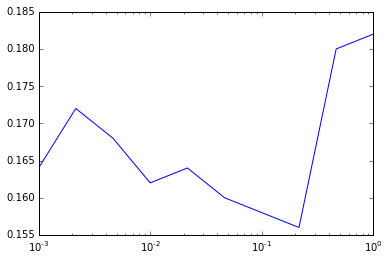

In [581]:
plt.plot(search_results1[0][:,0], search_results1[0][:,1])
plt.xscale('log')

In [590]:
print search_results1[0]

[[ 0.001       0.164     ]
 [ 0.00215443  0.172     ]
 [ 0.00464159  0.168     ]
 [ 0.01        0.162     ]
 [ 0.02154435  0.164     ]
 [ 0.04641589  0.16      ]
 [ 0.1         0.158     ]
 [ 0.21544347  0.156     ]
 [ 0.46415888  0.18      ]
 [ 1.          0.182     ]]


In [582]:
np.linspace(1e-1,1e-0,10)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [585]:
search_results2 = lambda_search(np.linspace(1e-1,1e-0,10), train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = False)

0.1
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.2
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.3
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.4
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.5
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.6
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.7
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.8
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.9
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
1.0
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


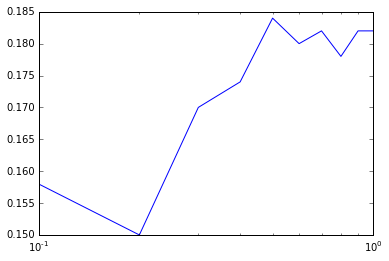

In [592]:
plt.plot(search_results2[0][:,0], search_results2[0][:,1])
plt.xscale('log')

In [591]:
print search_results2[0]

[[ 0.1    0.158]
 [ 0.2    0.15 ]
 [ 0.3    0.17 ]
 [ 0.4    0.174]
 [ 0.5    0.184]
 [ 0.6    0.18 ]
 [ 0.7    0.182]
 [ 0.8    0.178]
 [ 0.9    0.182]
 [ 1.     0.182]]


In [593]:
search_results3 = lambda_search(np.linspace(1e-1,3e-1,10), train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = False)

0.1
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.122222222222
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.144444444444
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.166666666667
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.188888888889
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.211111111111
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.233333333333
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.255555555556
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.277777777778
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.3
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


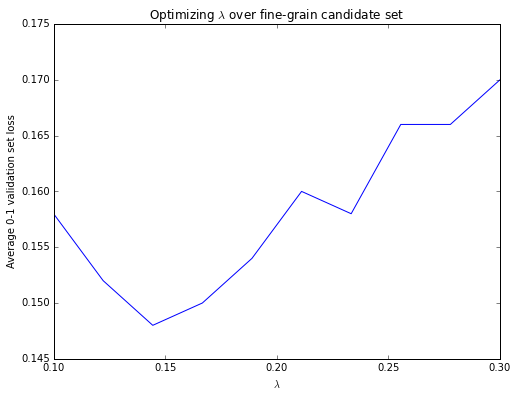

In [602]:
plt.figure(figsize=(8,6))
plt.plot(search_results3[0][:,0], search_results3[0][:,1])
plt.ylabel('Average 0-1 validation set loss')
plt.xlabel(r'$\lambda$')
plt.title(r'Optimizing $\lambda$ over fine-grain candidate set')
plt.savefig('figures/6_6_b.png')

In [595]:
search_results3[0]

array([[ 0.1       ,  0.158     ],
       [ 0.12222222,  0.152     ],
       [ 0.14444444,  0.148     ],
       [ 0.16666667,  0.15      ],
       [ 0.18888889,  0.154     ],
       [ 0.21111111,  0.16      ],
       [ 0.23333333,  0.158     ],
       [ 0.25555556,  0.166     ],
       [ 0.27777778,  0.166     ],
       [ 0.3       ,  0.17      ]])

In [597]:
search_results4 = lambda_search(np.linspace(1.2e-1,1.6e-1,5), train_data, test_data, max_epochs = 100, epsilon = 0.001, check_convergence = False)

0.12
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.13
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.14
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.15
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
0.16
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


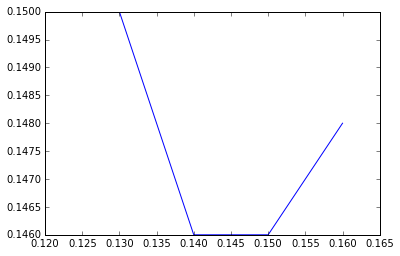

In [600]:
plt.plot(search_results4[0][:,0], search_results4[0][:,1])

In [607]:
search_results4[0]

array([[ 0.12 ,  0.15 ],
       [ 0.13 ,  0.15 ],
       [ 0.14 ,  0.146],
       [ 0.15 ,  0.146],
       [ 0.16 ,  0.148]])

In [617]:
opt_ws = ten_iter_results_W = sparse_SVM_via_pegasos_with_W(train_data, max_epochs=100, lambda_reg=0.14, epsilon = 0.001)

0.14
0.0
inside s==0 statement at t = 1.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


In [678]:
## First sparsify all test_:
sparse_testing = []
for obs in test_data:
    sparse_obs = {}
    sparse_obs['xi'] = sparsify(obs[:-1])
    sparse_obs['yi'] = obs[-1]
    sparse_testing.append(sparse_obs)
    
sparse_0_1_loss(opt_ws[0], sparse_testing)

0.146

# 6.7 Scores as "confidence" of prediction

In [619]:
np.linspace(-6, 6, 31)

array([-6. , -5.6, -5.2, -4.8, -4.4, -4. , -3.6, -3.2, -2.8, -2.4, -2. ,
       -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,
        2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ])

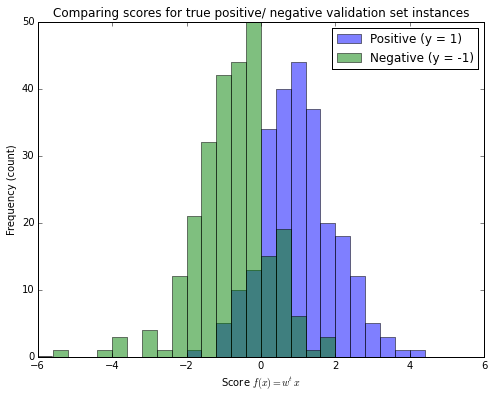

In [677]:
scores_actuals = []
for obs in test_data:
    scores_actuals.append([dotProduct(opt_ws[0], sparsify(obs[:-1])), obs[-1]])
scores_actuals = np.array(scores_actuals)

plt.figure(figsize=(8,6))
bins = np.linspace(-6, 6, 31)
pos_bins = plt.hist(scores_actuals[scores_actuals[:,1] == 1., 0], bins, alpha=0.5, label='Positive (y = 1)')
neg_bins = plt.hist(scores_actuals[scores_actuals[:,1] == -1., 0], bins, alpha=0.5, label='Negative (y = -1)')
plt.legend(loc='best')
plt.ylabel('Frequency (count)')
plt.xlabel(r'Score $f(x) = w^t x$')
plt.title("Comparing scores for true positive/ negative validation set instances")
plt.savefig('figures/6_7_a.png')

In [ ]:
pos_bins[0][0:15] ##False positive
pos_bins[0][15:] ##True positive
neg_bins[0][15:] ##False negative
neg_bins[0][0:15] ##True negative
pos_bins[0][0:15] + neg_bins[0][0:15]## Total bin counts in R-
pos_bins[0][15:] + neg_bins[0][15:] ## Total bin counts in R+

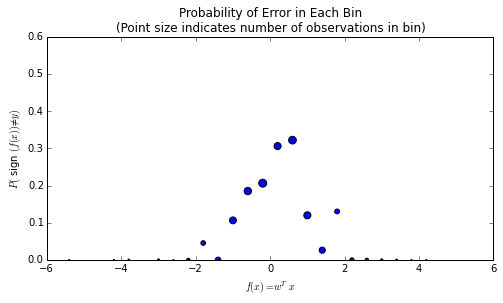

In [633]:
import matplotlib as mpl

handle0 = (lambda x: 1 if x == 0 else x)
handle0 = np.vectorize(handle0)

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(pos_bins[1][0:30]+.2,
            np.append(pos_bins[0][0:15]/handle0(pos_bins[0][0:15] + neg_bins[0][0:15]),
              neg_bins[0][15:]/handle0(pos_bins[0][15:] + neg_bins[0][15:])),
           s=(pos_bins[0][0:30] + neg_bins[0][0:30]))
ax.set_xlim(-6,6)
ax.set_ylim(0,0.6)
ax.set_ylabel(r'$P($ sign $(f(x)) \ne y)$')
ax.set_xlabel(r'$f(x) = w^Tx$')
ax.set_title('Probability of Error in Each Bin\n(Point size indicates number of observations in bin)')
plt.savefig('figures/6_7_b.png')

# 6.8 Number of score = 0 observations.

In [637]:
count_ywx_is_1 = 0
for obs in train_data:
    if obs[-1]*dotProduct(opt_ws[0], sparsify(obs[:-1])) == 1.0:
        count_ywx_is_1 += 1
print count_ywx_is_1

0


In [641]:
len(opt_ws[0])

38793

# 7.1 Error Analysis

In [653]:
def error_analysis():
    top_10_mistakes = []
    for obs in test_data:
        actual_score = dotProduct(opt_ws[0], sparsify(obs[:-1]))
        if np.sign(actual_score) != np.sign(obs[-1]):
            top_10_mistakes.append([obs[:-1], obs[-1], actual_score])
            min_val = min([np.abs(i[2]) for i in top_10_mistakes])
            if len(top_10_mistakes) > 10:
                new_list = [mistake for mistake in top_10_mistakes if np.abs(mistake[2]) != min_val]
                top_10_mistakes = new_list[:]

    num = 1
    for mistake in top_10_mistakes:
        product = {}
        for word, count in sparsify(mistake[0]).items():
            product[word] = np.abs(count*opt_ws[0][word])
        big_mistakes = sorted({v:k for k, v in product.items()}.items())[-10:-1]

        print 'Mistake {}-'.format(num), 'actual ranking = {}'.format(mistake[1]), ', score = {}'.format(mistake[2]),
        print '\n'
        for word in big_mistakes:
            word = word[1]
            print 'Word = {}, '.format(word), 'x = {}, '.format(round(sparsify(mistake[0])[word], 4)), 'w = {}, '.format(round(opt_ws[0][word], 4)), 'xw = {}'.format(round(sparsify(mistake[0])[word]*opt_ws[0][word],4))
        print '\n'
        num += 1
    
import sys
with open('error_examples.txt', 'w') as f:
    sys.stdout = f
    error_analysis()
    
sys.stdout = sys.__stdout__

# 8.2 Introducing bigram features

In [ ]:
shuffle_data(pickle_path = "all_data_bigrams_pickled.p", feature_set_func = read_data_bigrams)
train_bigram_data, test_bigram_data = train_test_split(num_train = 1500, num_test = 500, pickle_path = "all_data_bigrams_pickled.p")

In [ ]:
bigram_weights = sparse_SVM_via_pegasos_with_W(train_bigram_data, max_epochs=100, lambda_reg=0.14, epsilon = 0.01)

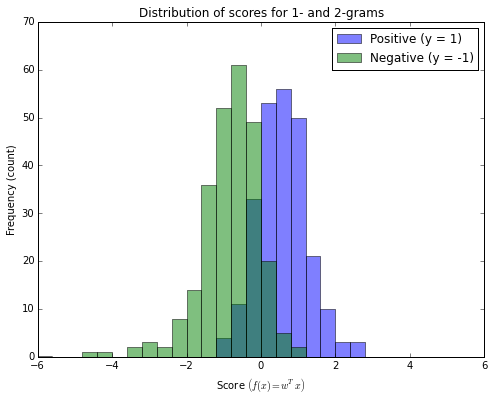

In [675]:
scores_actuals = []
for obs in test_bigram_data:
    scores_actuals.append([dotProduct(bigram_weights[0], sparsify(obs[:-1])), obs[-1]])
scores_actuals = np.array(scores_actuals)
plt.figure(figsize=(8,6))
bins = np.linspace(-6, 6, 31)
pos_bins = plt.hist(scores_actuals[scores_actuals[:,1] == 1., 0], bins, alpha=0.5, label='Positive (y = 1)')
neg_bins = plt.hist(scores_actuals[scores_actuals[:,1] == -1., 0], bins, alpha=0.5, label='Negative (y = -1)')
plt.legend(loc='best')
plt.title('Distribution of scores for 1- and 2-grams')
plt.xlabel(r'Score $\left(f(x) = w^T x \right)$')
plt.ylabel('Frequency (count)')
plt.savefig('figures/8_2_a.png')

In [683]:
## First sparsify all test_:
sparse_bigram_testing = []
for obs in test_bigram_data:
    sparse_obs = {}
    sparse_obs['xi'] = sparsify(obs[:-1])
    sparse_obs['yi'] = obs[-1]
    sparse_bigram_testing.append(sparse_obs)

p_hat = sparse_0_1_loss(bigram_weights[0], sparse_bigram_testing)
z_times_se = 1.96*((1-p_hat)*p_hat/len(sparse_bigram_testing))**0.5
print p_hat - z_times_se, p_hat + z_times_se, 

# 8.2 continued

In [657]:
## Toy data to simulate df/idf

a = Counter({'fish':1, 'dog':2})
b = Counter({'fish':2, 'god':2})
c = Counter({'fish':2, 'dog':1})

fake_data = [a,b,c]

DF = Counter()
for doc in fake_data:
    boolean = Counter(list(set(doc)))
    DF = DF + boolean

print DF
log_DF = {f: np.log(len(fake_data)/float(v)) for f,v in DF.items()}
print log_DF

for doc in fake_data:
    num_terms = float(sum(doc.values()))
    tf = {f: float(v)/num_terms for f, v in doc.items()}
    tf_IDF = {f: v*log_DF[f] for f, v in tf.items() if v*log_DF[f] != 0.0}
    print doc, tf_IDF
    

In [658]:
def tf_idf_conversion(training_data, test_data):
    tf_IDF_training_data = []
    tf_IDF_test_data = []    
    
    print 'starting to get DF'
    DF = Counter()
    for doc in training_data:
        boolean = Counter({word: 1.0 for word in doc[:-1]})
        DF = DF + boolean
    
    log_DF = Counter({f: np.log(len(training_data)/float(v)) for f,v in DF.items()})
    print 'got DF. starting tf_idf_conversion for training data'
    
    for doc in training_data:
        count_doc = Counter(doc[:-1])
        num_terms = float(sum(count_doc.values()))
        tf = {f: float(v)/num_terms for f, v in count_doc.items()}
        tf_IDF_training_data.append({'xi':{f: v*log_DF[f] for f, v in tf.items() if v*log_DF[f] != 0.0}, 'yi':doc[-1]})
    
    print 'got training data. starting tf_idf_conversion for testing data'
    for doc in test_data:
        count_doc = Counter(doc[:-1])
        num_terms = float(sum(count_doc.values()))
        tf = {f: float(v)/num_terms for f, v in count_doc.items()}
        tf_IDF_test_data.append({'xi':{f: v*log_DF[f] for f, v in tf.items() if v*log_DF[f] != 0.0}, 'yi':doc[-1]})
 
    return tf_IDF_training_data, tf_IDF_test_data

## TF-IDF with 1-grams

In [ ]:
tf_IDF_train_data, tf_IDF_test_data = tf_idf_conversion(train_data, test_data)
print 'Converted to tfidf'
tf_IDF_weights = sparse_SVM_via_pegasos_with_W(tf_IDF_train_data, max_epochs=100, lambda_reg=0.14, sparsified = True, epsilon = 0.0001)
print 'fit weights'


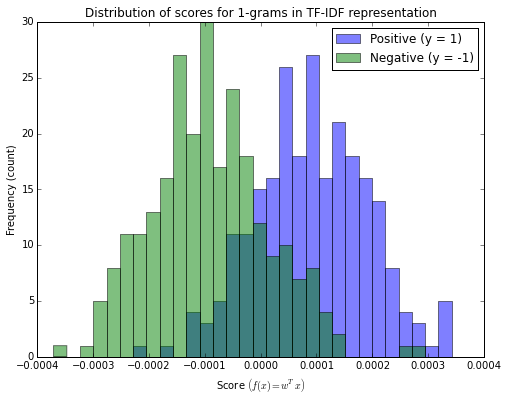

In [671]:
scores_actuals = []
for obs in tf_IDF_test_data:
    scores_actuals.append([dotProduct(tf_IDF_weights[0], obs['xi']), obs['yi']])
scores_actuals = np.array(scores_actuals)
plt.figure(figsize=(8,6))
bins = np.linspace(np.min(scores_actuals[:,0]), np.max(scores_actuals[:,0]), 31)
pos_bins = plt.hist(scores_actuals[scores_actuals[:,1] == 1., 0], bins, alpha=0.5, label='Positive (y = 1)')
neg_bins = plt.hist(scores_actuals[scores_actuals[:,1] == -1., 0], bins, alpha=0.5, label='Negative (y = -1)')
plt.legend(loc='best')
plt.title('Distribution of scores for 1-grams in TF-IDF representation')
plt.xlabel(r'Score $\left(f(x) = w^T x \right)$')
plt.ylabel('Frequency (count)')
plt.savefig('figures/8_2_b.png')

In [685]:
p_hat = sparse_0_1_loss(tf_IDF_weights[0], tf_IDF_test_data)
z_times_se = 1.96*((1-p_hat)*p_hat/len(tf_IDF_test_data))**0.5
print p_hat
print p_hat - z_times_se, p_hat + z_times_se, 

## TF-IDF with bigrams

In [663]:
tf_IDF_bigram_training_data, tf_IDF_bigram_test_data = tf_idf_conversion(train_bigram_data, test_bigram_data)
print 'Converted to tfidf'

In [664]:
tf_IDF_bigram_weights = sparse_SVM_via_pegasos_with_W(tf_IDF_bigram_training_data, max_epochs=100, lambda_reg=0.14, sparsified = True, epsilon = 0.0001)
print 'fit weights'

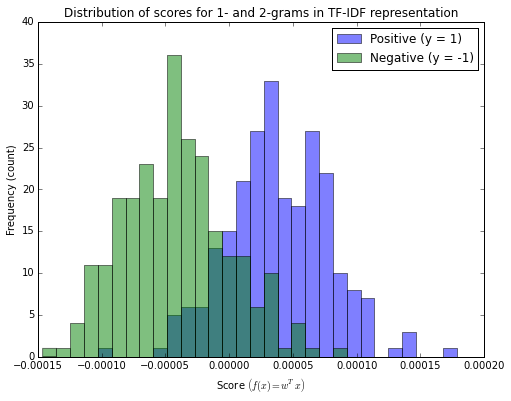

In [673]:
scores_actuals = []
for obs in tf_IDF_bigram_test_data:
    scores_actuals.append([dotProduct(tf_IDF_bigram_weights[0], obs['xi']), obs['yi']])
scores_actuals = np.array(scores_actuals)
plt.figure(figsize=(8,6))
bins = np.linspace(np.min(scores_actuals[:,0]), np.max(scores_actuals[:,0]), 31)
pos_bins = plt.hist(scores_actuals[scores_actuals[:,1] == 1., 0], bins, alpha=0.5, label='Positive (y = 1)')
neg_bins = plt.hist(scores_actuals[scores_actuals[:,1] == -1., 0], bins, alpha=0.5, label='Negative (y = -1)')
plt.legend(loc='best')
plt.title('Distribution of scores for 1- and 2-grams in TF-IDF representation')
plt.xlabel(r'Score $\left(f(x) = w^T x \right)$')
plt.ylabel('Frequency (count)')
plt.savefig('figures/8_2_c.png')

In [686]:
p_hat = sparse_0_1_loss(tf_IDF_bigram_weights[0], tf_IDF_bigram_test_data)
z_times_se = 1.96*((1-p_hat)*p_hat/len(tf_IDF_test_data))**0.5
print p_hat
print p_hat - z_times_se, p_hat + z_times_se, 